This notebook has the goal to provide a prediction of the income based on NURSERY dataset, taking account of the fairness, not only removing the protected attributes but also the proxies.

In [1]:
import pandas as pd
import sys
import matplotlib.pyplot as plt

In [2]:
sys.path.append('../')

In [3]:
nursery_dataset = pd.read_csv('./nursery.csv', sep=',')

In [4]:
nursery_dataset

parents   has_nurs      form children     housing     finance  \
0           usual     proper  complete        1  convenient  convenient   
1           usual     proper  complete        1  convenient  convenient   
2           usual     proper  complete        1  convenient  convenient   
3           usual     proper  complete        1  convenient  convenient   
4           usual     proper  complete        1  convenient  convenient   
...           ...        ...       ...      ...         ...         ...   
12955  great_pret  very_crit    foster     more    critical      inconv   
12956  great_pret  very_crit    foster     more    critical      inconv   
12957  great_pret  very_crit    foster     more    critical      inconv   
12958  great_pret  very_crit    foster     more    critical      inconv   
12959  great_pret  very_crit    foster     more    critical      inconv   

              social       health  output  
0            nonprob  recommended       1  
1            nonprob     priority       1  
2            nonprob    not_recom       0  
3      slightly_prob  recommended       1  
4      slightly_prob     priority       1  
...              ...          ...     ...  
12955  slightly_prob     priority       0  
12956  slightly_prob    not_recom       0  
12957    problematic  recommended       0  
12958    problematic     priority       0  
12959    problematic    not_recom       0  

[12960 rows x 9 columns]

After the dataset loading, it's time to perform all the operations on the dataset itself in order to perform the training step and the prediction step on a fair dataset. All the operations needed to guarantee that the resulting dataset is free are encapsulated into the **conscious_fairness_through_unawareness** method.
As reported into the method signature, this one requires some information:
* the dataset
* the list of protected attributes. In this case it has been chosen **children** as only protected attribute
* the values for the output column
* the output column
* the list of possible column to drop. In this case, after a consideration on the relevance of the attributes it has been established that no attributes would have been removed.

In [5]:
from sklearn.preprocessing import LabelEncoder

protected_attributes = ['children']
output_column = 'output'
nursery_dataset[output_column] = LabelEncoder().fit_transform(nursery_dataset[output_column])
output_column_values = nursery_dataset['output'].unique()

In [6]:
from fairness.matching import conscious_fairness_through_unawareness

fair_dataset = conscious_fairness_through_unawareness(nursery_dataset, protected_attributes, 
                                                      output_column_values, output_column, [])

fair


In [7]:
fair_dataset

parents  has_nurs  form  children  housing  finance  social  health  \
0            2         3     0         0        0        0       0       2   
1            2         3     0         0        0        0       0       1   
2            2         3     0         0        0        0       0       0   
3            2         3     0         0        0        0       2       2   
4            2         3     0         0        0        0       2       1   
...        ...       ...   ...       ...      ...      ...     ...     ...   
12955        0         4     2         1        1        1       2       1   
12956        0         4     2         1        1        1       2       0   
12957        0         4     2         1        1        1       1       2   
12958        0         4     2         1        1        1       1       1   
12959        0         4     2         1        1        1       1       0   

       output  
0           1  
1           1  
2           0  
3           1  
4           1  
...       ...  
12955       0  
12956       0  
12957       0  
12958       0  
12959       0  

[12960 rows x 9 columns]

Once we have the fair dataset it's important to move on with the training step and the prediction step

In [8]:
from sklearn.model_selection import train_test_split

X = fair_dataset.drop(columns=['output'], inplace=False)
y = fair_dataset['output']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

After the split of the dataset, the next step is to perform the calculations of the best parameters for the several models we want to use for the prediction step.Since this is a problem of multiclass classification, the chosen models are the following:

* RandomForest Classifier
* Logistic Regression
* DecisionTree Classifier

The best params for the RandomForest Classifier are:  {'criterion': 'log_loss', 'max_depth': 20, 'max_leaf_nodes': 40, 'n_estimators': 60}


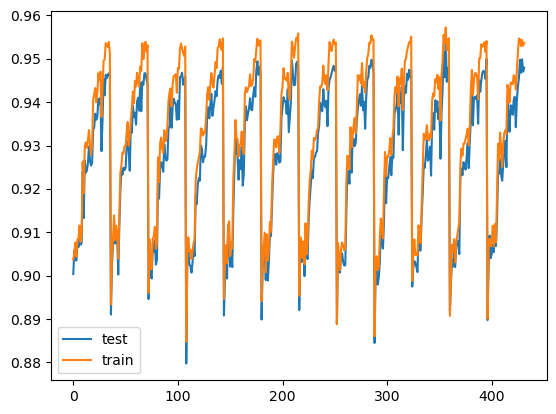

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

random_forest_model = RandomForestClassifier()
random_forest_params = {'n_estimators': range(10, 100, 10), 'criterion': ['gini', 'entropy', 'log_loss'], 
                        'max_depth': range(10, 50, 10), 'max_leaf_nodes': range(10, 50, 10)}

grid_search = GridSearchCV(random_forest_model, param_grid=random_forest_params, cv=10, return_train_score=True)
random_forest = grid_search.fit(X_train, y_train)

print("The best params for the RandomForest Classifier are: ", random_forest.best_params_)

test_scores = random_forest.cv_results_['mean_test_score']
train_scores = random_forest.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

Accuracy for random_forest:  0.9544072948328267


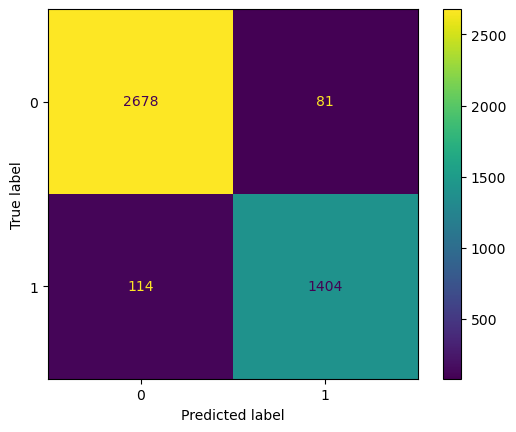

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

predicted_result = random_forest.predict(X_test)
accuracy = accuracy_score(y_test, predicted_result)
print("Accuracy for random_forest: ", accuracy)

matrix = confusion_matrix(y_test, predicted_result, labels=random_forest.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=random_forest.classes_)
display.plot()
plt.show()

The best params for the Logistic Regression are:  {'penalty': 'l2', 'solver': 'lbfgs'}


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
130 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 61, in _check_solver
    raise ValueError(
ValueError: Sol

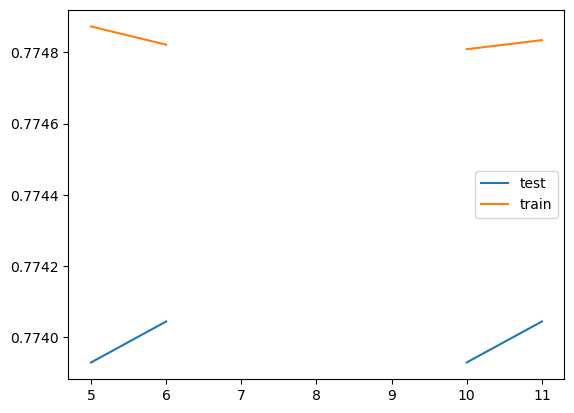

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logistic_regression_model = LogisticRegression(multi_class='multinomial')
logistic_regression_params = {'penalty': ['l1', 'l2', 'elasticnet'], 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

grid_search = GridSearchCV(logistic_regression_model, param_grid=logistic_regression_params, cv=10, return_train_score=True)
logistic_regression = grid_search.fit(X_train, y_train)

print("The best params for the Logistic Regression are: ", logistic_regression.best_params_)

test_scores = logistic_regression.cv_results_['mean_test_score']
train_scores = logistic_regression.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

Accuracy for logistic regression:  0.7865326163198504


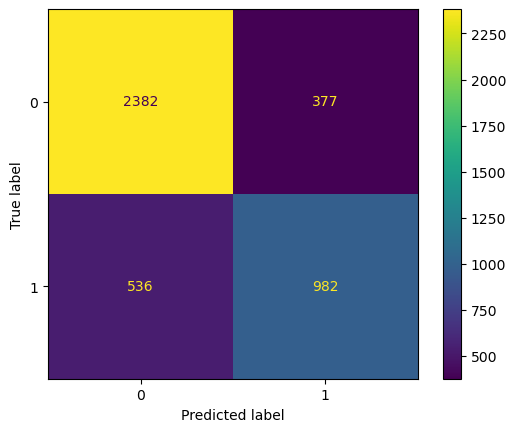

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predicted_result = logistic_regression.predict(X_test)
accuracy = accuracy_score(y_test, predicted_result)
print("Accuracy for logistic regression: ", accuracy)

matrix = confusion_matrix(y_test, predicted_result, labels=logistic_regression.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=logistic_regression.classes_)
display.plot()
plt.show()

The best params for DecisionTree Classifier are:  {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 40}


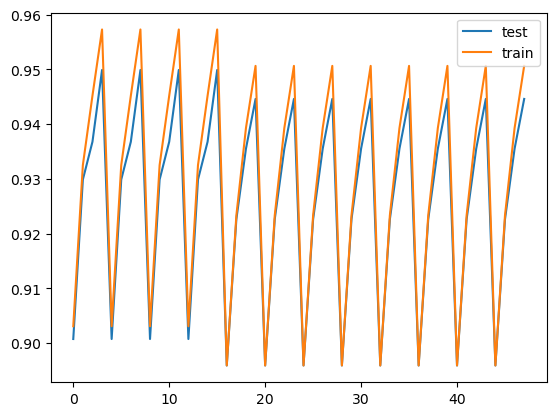

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

decision_tree_model = DecisionTreeClassifier()
decision_tree_params = {'criterion': ['gini', 'entropy', 'log_loss'], 
                        'max_depth': range(10, 50, 10), 'max_leaf_nodes': range(10, 50, 10)}

grid_search = GridSearchCV(decision_tree_model, param_grid=decision_tree_params, cv=10, return_train_score=True)
decision_tree = grid_search.fit(X_train, y_train)
best_params = decision_tree.best_params_
print("The best params for DecisionTree Classifier are: ", best_params)

test_scores = decision_tree.cv_results_['mean_test_score']
train_scores = decision_tree.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

Accuracy for decision tree classifier:  0.9534720598550386


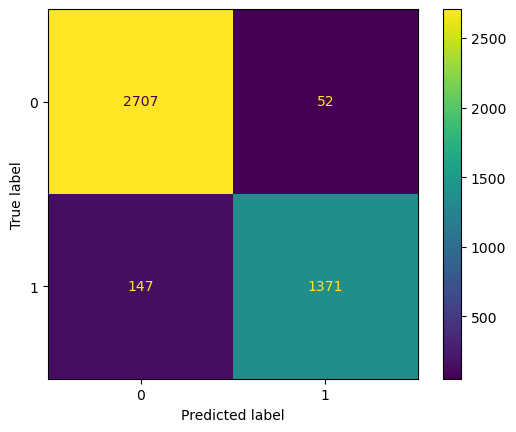

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predicted_result = decision_tree.predict(X_test)
accuracy = accuracy_score(y_test, predicted_result)
print("Accuracy for decision tree classifier: ", accuracy)

matrix = confusion_matrix(y_test, predicted_result, labels=decision_tree.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=decision_tree.classes_)
display.plot()
plt.show()